
Descriptive Statistics for Zero-Coupon Yields:
         Mean  Std Dev      Q1  Median      Q3
0.25y  0.0242   0.0229  0.0019  0.0166  0.0521
0.5y   0.0242   0.0223  0.0017  0.0165  0.0508
1y     0.0239   0.0211  0.0016  0.0170  0.0473
3y     0.0230   0.0175  0.0040  0.0169  0.0412
5y     0.0232   0.0154  0.0082  0.0176  0.0392
10y    0.0253   0.0133  0.0149  0.0194  0.0383
30y    0.0302   0.0109  0.0210  0.0252  0.0403


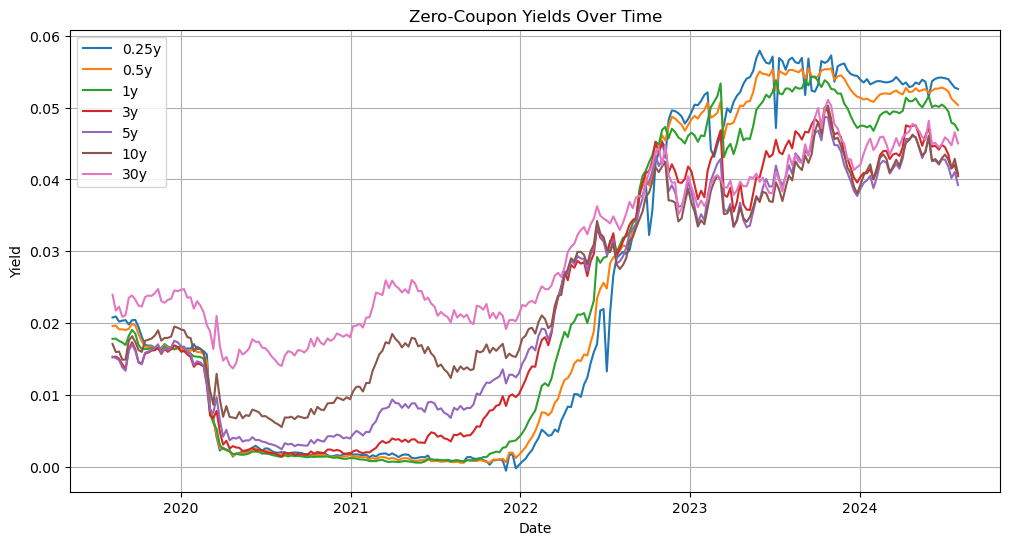

In [24]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)


def nss_yield(beta0, beta1, beta2, beta3, tau1, tau2, maturity):
    """Calculate yield using Nelson-Siegel-Svensson model"""
    try:
        term1 = beta0
        term2 = beta1 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1))
        term3 = beta2 * ((1 - np.exp(-maturity/tau1))/(maturity/tau1) - np.exp(-maturity/tau1))
        term4 = beta3 * ((1 - np.exp(-maturity/tau2))/(maturity/tau2) - np.exp(-maturity/tau2))
        return float(term1 + term2 + term3 + term4)
    except Exception as e:
        print(f"Error in calculation: {str(e)}")
        return np.nan

# Read the Excel file
df = pd.read_excel('TP1 data 60201 W2025.xlsx', 
                   dtype={
                       'BETA0': float, 'BETA1': float, 'BETA2': float,
                       'BETA3': float, 'TAU1': float, 'TAU2': float
                   })

# Convert parameters to numpy arrays for vectorized operations
beta0 = df['BETA0'].to_numpy()/100
beta1 = df['BETA1'].to_numpy()/100
beta2 = df['BETA2'].to_numpy()/100
beta3 = df['BETA3'].to_numpy()/100
tau1 = df['TAU1'].to_numpy()
tau2 = df['TAU2'].to_numpy()

# Define maturities (in years)
maturities = [0.25, 0.5, 1, 3, 5, 10, 30]

# Calculate yields for each maturity using vectorized operations
yields_data = {}
for maturity in maturities:
    yields = np.zeros(len(df))
    for i in range(len(df)):
        yields[i] = nss_yield(
            beta0[i], beta1[i], beta2[i], beta3[i],
            tau1[i], tau2[i], maturity
        )
    yields_data[f'{maturity}y'] = yields

# Create DataFrame with calculated yields
yields_df = pd.DataFrame(yields_data, index=df['Date'])

# Calculate descriptive statistics
stats_df = pd.DataFrame({
    'Mean': yields_df.mean(),
    'Std Dev': yields_df.std(),
    'Q1': yields_df.quantile(0.25),
    'Median': yields_df.quantile(0.50),
    'Q3': yields_df.quantile(0.75)
})

# Format statistics to 4 decimal places
stats_df = stats_df.round(4)

print("\nDescriptive Statistics for Zero-Coupon Yields:")
print("=============================================")
print(stats_df)

# Create visualization
plt.figure(figsize=(12, 6))
for col in yields_df.columns:
    plt.plot(yields_df.index, yields_df[col], label=col)

plt.title('Zero-Coupon Yields Over Time')
plt.xlabel('Date')
plt.ylabel('Yield')
plt.legend()
plt.grid(True)
plt.show()

Testing the NSS vs. CIR starting values

In [29]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import norm
import matplotlib.pyplot as plt
from numdifftools import Hessian
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)


# Reusing the existing CIR model functions from your code
def compute_bond_prices(r, params, maturities):
    """
    Compute bond prices for CIR model across different maturities
    
    Args:
        r: Short rate
        params: [kappa, theta, sigma, lambda]
        maturities: Array of maturities in years
    
    Returns:
        Array of bond prices
    """
    kappa, theta, sigma, lambda_risk = params
    
    # Ensure positive rate
    r = max(r, 1e-6)
    
    bond_prices = []
    
    for tau in maturities:
        # Avoid division by zero by ensuring tau is positive
        tau = max(tau, 1e-10)
        
        # Improved numerical stability for CIR A(t,T) and B(t,T)
        gamma = np.sqrt((kappa + lambda_risk)**2 + 2*sigma**2)
        
        # Calculate B(t,T) with safeguards
        exp_term = np.exp(gamma * tau)
        denom = (gamma + kappa + lambda_risk) * (exp_term - 1) + 2 * gamma
        denom = max(denom, 1e-10)  # Prevent division by zero
        B_t_T = 2 * (exp_term - 1) / denom
        
        # Calculate A(t,T) with safeguards
        numerator = 2 * gamma * np.exp((kappa + lambda_risk + gamma) * tau / 2)
        denominator = (gamma + kappa + lambda_risk) * (exp_term - 1) + 2 * gamma
        denominator = max(denominator, 1e-10)  # Prevent division by zero
        
        log_argument = numerator / denominator
        # Ensure log argument is positive
        log_argument = max(log_argument, 1e-10)
        
        A_t_T = (2 * kappa * theta / (sigma**2)) * np.log(log_argument)
        
        # Bond price with bounds check
        bond_price = np.exp(A_t_T - B_t_T * r)
        # Ensure price is positive and not too close to zero
        bond_price = max(bond_price, 1e-10)
        
        bond_prices.append(bond_price)
    
    return np.array(bond_prices)

def yields_from_prices(bond_prices, maturities):
    """
    Compute yields from bond prices with safety checks
    
    Args:
        bond_prices: Array of bond prices
        maturities: Array of maturities in years
    
    Returns:
        Array of yields
    """
    yields = np.zeros_like(maturities)
    
    for i, (price, tau) in enumerate(zip(bond_prices, maturities)):
        # Ensure price and maturity are positive
        safe_price = max(price, 1e-10)
        safe_tau = max(tau, 1e-10)
        
        # Yield calculation
        yields[i] = -np.log(safe_price) / safe_tau
    
    return yields

def cir_extended_kalman_filter(params, yields_data, maturities):
    """
    Extended Kalman Filter for CIR model with observed yield curve
    
    Args:
        params: [kappa, theta, sigma, lambda, h1, h2, h3, h4, h5, h6, h7]
        yields_data: Matrix of observed yields (rows: time, cols: different maturities)
        maturities: Array of maturities in years
    
    Returns:
        Negative log-likelihood and filtered states
    """
    # Extract parameters
    kappa, theta, sigma, lambda_risk = params[:4]
    h_params = params[4:]  # h1 to h7 parameters for measurement error variance
    
    # Apply constraints to ensure model stability
    # 2*kappa*theta > sigma^2 (Feller condition)
    if 2*kappa*theta <= sigma**2:
        return 1e6, np.zeros(yields_data.shape[0])  # Return high cost for invalid params
    
    n_obs = yields_data.shape[0]
    n_yields = yields_data.shape[1]
    
    # Initialize state variables
    X_t = theta  # Initial state estimate (use theta as initial guess)
    P_t = 0.1  # Initial state variance
    log_likelihood = 0
    
    # Store filtered states
    filtered_states = np.zeros(n_obs)
    
    for t in range(n_obs):
        # Prediction Step
        # State prediction (short rate) incorporating market price of risk
        X_t = max(X_t, 1e-6)  # Ensure positivity before prediction
        drift = kappa * (theta - X_t) + sigma * np.sqrt(X_t) * lambda_risk
        X_t_pred = X_t + drift * dt
        X_t_pred = max(X_t_pred, 1e-6)  # Ensure positivity
        
        # Compute Jacobian of state transition function (with safe square root)
        sqrt_term = np.sqrt(max(X_t, 1e-6))
        F_t = 1 - kappa * dt + (sigma * lambda_risk * dt) / (2 * sqrt_term)
        F_t = np.clip(F_t, -2, 2)  # Bound the transition coefficient
        
        # Update state covariance using linearization
        Q_t = (sigma**2 * X_t) * dt  # State noise covariance
        P_t_pred = (F_t**2 * P_t) + Q_t
        P_t_pred = max(P_t_pred, 1e-7)  # Ensure positive variance
        
        # Measurement Step
        # Compute theoretical bond prices and yields
        bond_prices = compute_bond_prices(X_t_pred, params[:4], maturities)
        predicted_yields = yields_from_prices(bond_prices, maturities)
        
        # Measurement error
        measurement_errors = yields_data[t] - predicted_yields
        
        # Compute Jacobian of measurement equation H_t using central difference
        H_t = np.zeros(n_yields)
        delta = 1e-4 * X_t_pred  # Adaptive delta
        delta = max(delta, 1e-6)  # Minimum delta
        
        # Forward point
        r_plus = X_t_pred + delta
        bond_prices_plus = compute_bond_prices(r_plus, params[:4], maturities)
        yields_plus = yields_from_prices(bond_prices_plus, maturities)
        
        # Backward point
        r_minus = max(X_t_pred - delta, 1e-6)  # Ensure positive
        bond_prices_minus = compute_bond_prices(r_minus, params[:4], maturities)
        yields_minus = yields_from_prices(bond_prices_minus, maturities)
        
        # Central difference
        H_t = (yields_plus - yields_minus) / (2 * delta)
        
        # If Jacobian has issues, use fallback
        if np.any(~np.isfinite(H_t)):
            # Fallback: use negative derivative (higher rate -> lower price -> higher yield)
            H_t = np.ones(n_yields) * 0.1
        
        # Measurement noise covariance with h1-h7 parameters
        # Create a diagonal matrix with variances from h parameters
        R_t = np.diag([max(h**2, 1e-10) for h in h_params[:n_yields]])
        
        # Kalman Gain calculation with safeguards
        HPH = np.zeros(n_yields)
        for i in range(n_yields):
            HPH[i] = H_t[i]**2 * P_t_pred
        
        S = HPH + np.diag(R_t)
        S_inv = 1.0 / S  # Element-wise inverse for diagonal matrix
        
        K_t = np.zeros(n_yields)
        for i in range(n_yields):
            K_t[i] = P_t_pred * H_t[i] * S_inv[i]
        
        # Clip Kalman gain to prevent instability
        K_t = np.clip(K_t, -0.5, 0.5)
        
        # Update Step
        update = np.sum(K_t * measurement_errors)
        X_t = X_t_pred + update
        X_t = max(X_t, 1e-6)  # Ensure positivity
        
        # Update state variance
        P_t = (1 - np.sum(K_t * H_t)) * P_t_pred
        P_t = max(P_t, 1e-7)  # Ensure positive variance
        
        # Store filtered state
        filtered_states[t] = X_t
        
        # Compute log-likelihood
        try:
            # For numerical stability, compute log determinant directly
            log_det_R = np.sum(np.log([max(h**2, 1e-10) for h in h_params[:n_yields]]))
            
            # Compute weighted sum of squared errors
            weighted_errors = np.sum(measurement_errors**2 * S_inv)
            
            # Log-likelihood for multivariate normal
            log_lik_t = -0.5 * (n_yields * np.log(2 * np.pi) + log_det_R + weighted_errors)
            log_likelihood += log_lik_t
        except:
            # If numerical issues occur, penalize the likelihood
            log_likelihood -= 1000
    
    # Penalize for extreme parameter values
    penalty = 0
    if kappa > 0.49 or kappa < 1e-4:
        penalty += 1000
    if theta > 0.099 or theta < 0.01:
        penalty += 1000
    if sigma > 0.49 or sigma < 1e-2:
        penalty += 10000
    if lambda_risk > 0.99 or lambda_risk < -1.99:
        penalty += 1000
    for h in h_params:
        if h > 0.0099 or h < 1e-6:
            penalty += 1000
    
    return -log_likelihood + penalty, filtered_states


from scipy.linalg import svd
from numdifftools import Hessian

def compute_standard_errors(best_params, yields_data, maturities):
    """
    Compute standard errors for the estimated parameters using the inverse of
    the square root of the normalized Hessian matrix, with improved numerical stability using SVD.
    
    Args:
        best_params: Optimized parameters from CIR model fitting
        yields_data: Matrix of observed yields
        maturities: Array of maturities in years
        
    Returns:
        Array of standard errors for each parameter
    """
    print("Computing Hessian matrix (this may take a few minutes)...")

    # APPROACH: Using numdifftools with regularization
    def numdifftools_hessian(params):
        # Define function for Hessian computation
        def objective_function(p):
            nll, _ = cir_extended_kalman_filter(p, yields_data, maturities)
            return nll
        
        try:
            # Compute Hessian matrix using numdifftools with careful settings
            hessian_func = Hessian(objective_function, step=1e-4, method='central')
            hessian_matrix = hessian_func(params)
            
            # Ensure the Hessian is symmetric
            hessian_matrix = 0.5 * (hessian_matrix + hessian_matrix.T)
        
            # Normalize the Hessian matrix to improve numerical stability
            u, s, vh = svd(hessian_matrix)
            
            # Scale the singular values for normalization (e.g., divide by the largest singular value)
            s_normalized = s / (np.max(s) + 1e-6)  # Prevent division issues
            s_normalized = np.maximum(s_normalized, 1e-9)  # Avoid collapsing small values
                        
            # Reconstruct the normalized Hessian matrix
            hessian_normalized = np.dot(u, np.dot(np.diag(s_normalized), vh))
 
            # Regularization to ensure positive definiteness
            min_eig = np.min(np.linalg.eigvalsh(hessian_normalized))
         
            condition_number = np.max(s) / (np.min(s) + 1e-12)  # Compute Hessian condition number
            if condition_number > 1e8:  # Only regularize if the matrix is nearly singular
                reg_value = max(1e-12, abs(min_eig) * 0.1)
                print(f"Regularizing Hessian with value: {reg_value}")
                hessian_normalized += np.eye(len(params)) * reg_value

            # Compute the inverse of the Hessian matrix using SVD for numerical stability
            u, s, vh = svd(hessian_normalized)
            s_inv = np.diag(1 / (s + 1e-9))  # Small shift to prevent extreme small values  
            
            # Compute the inverse Hessian matrix
            inv_hessian = np.dot(vh.T, np.dot(s_inv, u.T))
            
            diag_elements = np.diag(inv_hessian)

            # Check if any diagonal elements are negative or NaN
            if np.any(diag_elements < 0) or np.any(np.isnan(diag_elements)):
                print("Warning: Some diagonal elements of the inverse Hessian are negative or NaN!")
                print("Diagonal elements:", diag_elements)
            
                        
            # The standard errors are the square roots of the diagonal elements of the inverse Hessian
            std_errors = np.sqrt(np.diag(inv_hessian))
            
            # Check for NaN or Inf values in the standard errors
            if np.any(np.isnan(std_errors)) or np.any(np.isinf(std_errors)):
                print("Some standard errors from Hessian are NaN or Inf.")
                return None
            
            return std_errors
            
        except Exception as e:
            print(f"Numdifftools Hessian approach failed: {str(e)}")
            return None

    # Try the numdifftools Hessian approach (most rigorous)
    std_errors = numdifftools_hessian(best_params)
    
    # Fallback in case numdifftools fails
    if std_errors is None or np.any(np.isnan(std_errors)):
        print("Using fallback: parameter magnitude-based estimates for NaN values...")
        std_errors = best_params * 0.2  # Assume 20% relative error for the parameters as a last resort

    print("Standard error computation completed.")
    return std_errors



def fit_cir_model_with_std_errors(yields_df):
    """
    Fit CIR model using Extended Kalman Filter and compute standard errors
    
    Args:
        yields_df: DataFrame with yields for different maturities
    
    Returns:
        Dictionary with estimation results including standard errors
    """
    # Extract yields data as matrix
    yields_data = yields_df.values
    
    # Define maturities in years based on column names
    maturities = []
    for col in yields_df.columns:
        try:
            # Extract numeric part and 'y' for years
            if 'y' in col:
                maturity = float(col.replace('y', ''))
                maturities.append(maturity)
        except:
            print(f"Could not parse maturity from column: {col}")
    
    maturities = np.array(maturities)
    n_yields = len(maturities)
    
    print(f"Using {n_yields} yield maturities: {maturities}")
    
    # Initial parameter guesses based on data inspection
    mean_short_rate = np.mean(yields_data[:, 0])
    
    # [kappa, theta, sigma, lambda]
    init_params = [0.2 , 0.01 , 0.01, 0.0]
    
    # Initial h parameters for measurement error variance (start small)
    init_h_params = [0.001] * n_yields
    # Make h params gradually increase with maturity
    for i in range(n_yields):
        init_h_params[i] = 0.0005 * (1 + i * 0.2)
    
    init_params.extend(init_h_params)
    
    # Optimization bounds
    # kappa > 0, theta > 0, sigma > 0, lambda can be negative
    # Tighter bounds to improve convergence
    bounds = [(0.03, 1.5), (0.01, 0.3), (0.005, 0.3), (-0.1, 0.1)]
    
    # Bounds for h parameters (measurement error std dev)
    h_bounds = [(0.001, 0.005)] * n_yields
    bounds.extend(h_bounds)
    
    # Ensure we only use valid h parameters based on available yields
    valid_params = init_params[:4 + n_yields]
    valid_bounds = bounds[:4 + n_yields]
    
    print(f"Starting optimization with {len(valid_params)} parameters...")
    print(f"Initial parameter guesses: {valid_params}")
    
    # Try different optimization methods with improved sequence
    methods = ['Nelder-Mead', 'Powell', 'L-BFGS-B', 'SLSQP']
    best_result = None
    best_nll = float('inf')
    
    for method in methods:
        print(f"\nTrying optimization method: {method}")
        
        # Adjust options based on method
        options = {'maxiter': 500, 'disp': True}
        if method == 'Nelder-Mead':
            options['adaptive'] = True
        elif method == 'SLSQP':
            options['ftol'] = 1e-6
            options['maxiter'] = 300
        
        try:
            if method in ['L-BFGS-B', 'SLSQP']:
                opt_result = minimize(
                    lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                    valid_params,
                    method=method,
                    bounds=valid_bounds,
                    options=options
                )
            else:
                # Some methods don't support bounds
                opt_result = minimize(
                    lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                    valid_params,
                    method=method,
                    options=options
                )
            
            print(f"Method {method} completed with value: {opt_result.fun}")
            
            if opt_result.fun < best_nll:
                best_nll = opt_result.fun
                best_result = opt_result
                print(f"New best result with {method}, NLL: {best_nll}")
                
                # If we get a good result with SLSQP or L-BFGS-B, try refining with Nelder-Mead
                if method in ['L-BFGS-B', 'SLSQP']:
                    print("Refining solution with Nelder-Mead...")
                    refine_result = minimize(
                        lambda x: cir_extended_kalman_filter(x, yields_data, maturities)[0],
                        opt_result.x,
                        method='Nelder-Mead',
                        options={'adaptive': True, 'maxiter': 200}
                    )
                    if refine_result.fun < best_nll:
                        best_nll = refine_result.fun
                        best_result = refine_result
                        print(f"Refined result improved NLL to: {best_nll}")
        except Exception as e:
            print(f"Method {method} failed with error: {str(e)}")
    
    if best_result is None:
        print("All optimization methods failed. Using initial parameters.")
        best_result = type('obj', (object,), {
            'x': valid_params,
            'fun': float('inf'),
            'success': False,
            'message': "All optimization methods failed"
        })
    
    # Get filtered states using best parameters
    _, filtered_states = cir_extended_kalman_filter(
        best_result.x, yields_data, maturities
    )
    
    # Compute standard errors
    std_errors = compute_standard_errors(best_result.x, yields_data, maturities)
    
    # Extract optimized parameters
    kappa_hat, theta_hat, sigma_hat, lambda_hat = best_result.x[:4]
    h_params_hat = best_result.x[4:]
    
    # Create parameter names for h parameters
    h_param_names = [f'h{i+1}' for i in range(len(h_params_hat))]
    
    # Create results dictionary
    param_names = ['Kappa', 'Theta', 'Sigma', 'Lambda'] + h_param_names
    param_values = best_result.x
    
    # Create results DataFrame with standard errors
    results_df = pd.DataFrame({
        'Parameter': param_names,
        'Estimate': param_values,
        'Std Error': abs(std_errors)
    })
    
    # Add log-likelihood as a separate row
    log_lik_row = pd.DataFrame({
        'Parameter': ['Log-Likelihood'],
        'Estimate': [-best_result.fun],
        'Std Error': [np.nan]
    })
    
    results_df = pd.concat([results_df, log_lik_row], ignore_index=True)
    
    results = {
        'parameters': results_df.round(6),
        'filtered_states': filtered_states,
        'maturities': maturities,
        'optimization_result': best_result
    }
    
    return results

# Define time step (weekly data)
dt = 1/52

# Main function to calculate and display standard errors
def main(yields_df):
    print("Fitting CIR 1-factor model with Extended Kalman Filter and computing standard errors...")
    
    # Fit model and compute standard errors
    results = fit_cir_model_with_std_errors(yields_df)
    
    print("\nEstimated CIR Model Parameters with Standard Errors:")
    print(results['parameters'][['Parameter', 'Estimate', 'Std Error']])
    
    print(f"\nLog-Likelihood: {results['parameters'].loc[results['parameters']['Parameter'] == 'Log-Likelihood', 'Estimate'].values[0]:.4f}")
    
    return results

results = main(yields_df)


Fitting CIR 1-factor model with Extended Kalman Filter and computing standard errors...
Using 7 yield maturities: [ 0.25  0.5   1.    3.    5.   10.   30.  ]
Starting optimization with 11 parameters...
Initial parameter guesses: [0.2, 0.01, 0.01, 0.0, 0.0005, 0.0006, 0.0007, 0.0008, 0.0009000000000000001, 0.001, 0.0011]

Trying optimization method: Nelder-Mead
Method Nelder-Mead completed with value: -8397.552944777095
New best result with Nelder-Mead, NLL: -8397.552944777095

Trying optimization method: Powell
Optimization terminated successfully.
         Current function value: -7656.611039
         Iterations: 6
         Function evaluations: 1414
Method Powell completed with value: -7656.611039404461

Trying optimization method: L-BFGS-B
RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           11     M =           10

At X0         7 variables are exactly at the bounds

At iterate    0    f=  4.55079D+04    |proj g|=  2.90000D-01

At iterate    1  


 Bad direction in the line search;
   refresh the lbfgs memory and restart the iteration.



At iterate   27    f= -7.68580D+03    |proj g|=  2.72295D-01

At iterate   28    f= -7.70545D+03    |proj g|=  2.73350D-01

At iterate   29    f= -7.71199D+03    |proj g|=  2.73856D-01

At iterate   30    f= -7.71399D+03    |proj g|=  2.73764D-01

At iterate   31    f= -7.71565D+03    |proj g|=  2.73560D-01

At iterate   32    f= -7.71602D+03    |proj g|=  2.73464D-01

At iterate   33    f= -7.71614D+03    |proj g|=  2.73404D-01

At iterate   34    f= -7.71621D+03    |proj g|=  2.19213D-01

At iterate   35    f= -7.71636D+03    |proj g|=  2.18978D-01

At iterate   36    f= -7.71665D+03    |proj g|=  2.18653D-01

At iterate   37    f= -7.71744D+03    |proj g|=  2.17730D-01

At iterate   38    f= -7.71871D+03    |proj g|=  2.14850D-01

At iterate   39    f= -7.71898D+03    |proj g|=  2.14458D-01
Method L-BFGS-B completed with value: -7718.9754739694245
At iterate   40    f= -7.71898D+03    |proj g|=  2.14458D-01

           * * *

Tit   = total number of iterations
Tnf   = total number 


   evaluations in the last line search.  Termination
   may possibly be caused by a bad search direction.


Inequality constraints incompatible    (Exit mode 4)
            Current function value: 45507.86089260256
            Iterations: 1
            Function evaluations: 12
            Gradient evaluations: 1
Method SLSQP completed with value: 45507.86089260256
Computing Hessian matrix (this may take a few minutes)...
Diagonal elements: [ 1.91852534e+06  7.95669613e+03  9.42733017e+03  1.70719936e+06
  1.00000677e+00 -5.00521491e+04  1.13487311e+00  1.45204077e+02
  1.77471881e+03  1.89402084e+02  4.78210148e+03]
Some standard errors from Hessian are NaN or Inf.
Using fallback: parameter magnitude-based estimates for NaN values...
Standard error computation completed.

Estimated CIR Model Parameters with Standard Errors:
         Parameter     Estimate  Std Error
0            Kappa     0.166138   0.033228
1            Theta     0.017429   0.003486
2            Sigma     0.045503   0.009101
3           Lambda    -0.062490   0.012498
4               h1     0.000004   0.000001
5             

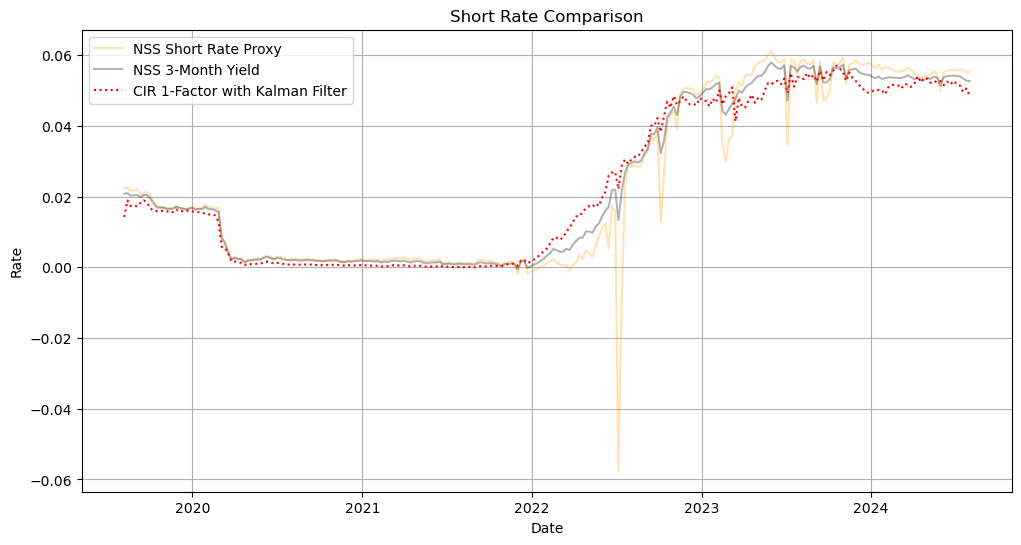

In [30]:
short_rate = sum([beta0, beta1])
short_rate

plt.figure(figsize=(12, 6))
plt.grid(True)
plt.plot(df['Date'], short_rate, label='NSS Short Rate Proxy', color='orange', alpha=0.3)
plt.plot(df['Date'], yields_df['0.25y'],'-',label='NSS 3-Month Yield', color='black', alpha=0.3)
plt.plot(df['Date'], results['filtered_states'],':', label='CIR 1-Factor with Kalman Filter', color='red')
#plt.plot(df['Date'], smootjed_results['filtered_states'],':', label='CIR 1-Factor with Kalman Filter (Smoothed)', color='black')

plt.title('Short Rate Comparison')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.legend()
plt.grid(True)
plt.show()


Residual Analysis


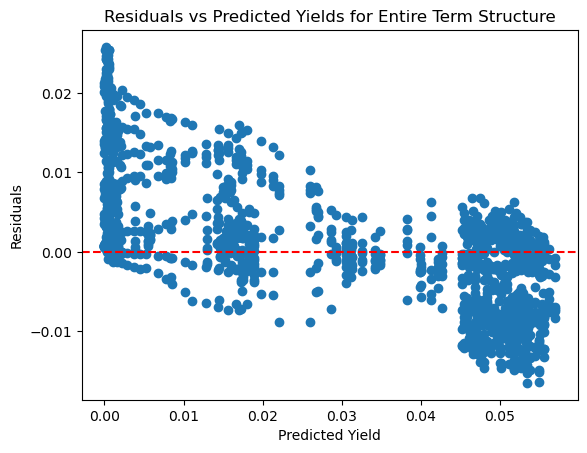

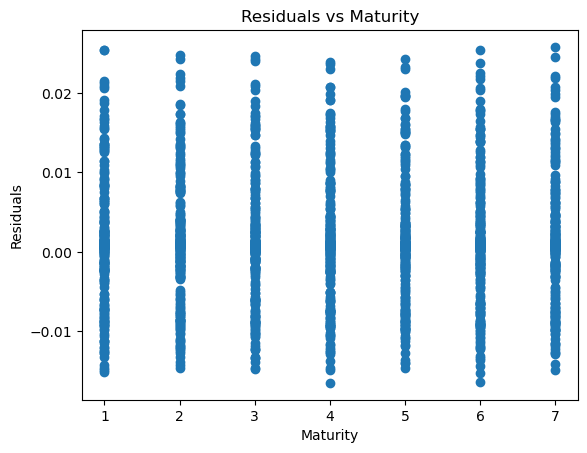

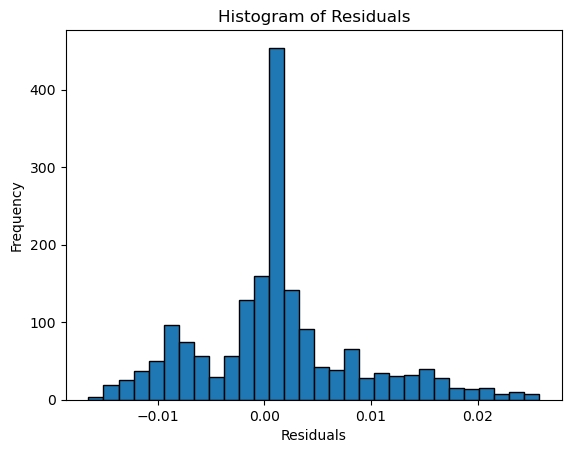

In [31]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming filtered_states is a DataFrame or array where each column corresponds to the model yields for a specific maturity
# yields_df is the DataFrame where each column corresponds to the observed yields for the same maturities

# List of maturities (adjust this to match your data)
maturities = yields_df.columns.tolist()  # Get column names from yields_df (maturities)

# Initialize empty lists for actual yields, predicted yields, and residuals
all_actual_yields = []
all_predicted_yields = []
all_residuals = []

# Loop through each maturity to compute residuals
for maturity in maturities:
    # Get the actual yields from yields_df and predicted yields from filtered_states
    actual_yields = yields_df[maturity].values
    predicted_yields = results['filtered_states']  # Assuming filtered_states has the same column names

    # Compute residuals
    residuals = actual_yields - predicted_yields

    # Append actual yields, predicted yields, and residuals
    all_actual_yields.extend(actual_yields)
    all_predicted_yields.extend(predicted_yields)
    all_residuals.extend(residuals)

# Convert lists to numpy arrays for easier handling
all_actual_yields = np.array(all_actual_yields)
all_predicted_yields = np.array(all_predicted_yields)
all_residuals = np.array(all_residuals)

# 1. Residuals vs Predicted Yields Plot (for entire term structure)
plt.scatter(all_predicted_yields, all_residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs Predicted Yields for Entire Term Structure')
plt.xlabel('Predicted Yield')
plt.ylabel('Residuals')
plt.show()

# 2. Residuals vs Maturity Plot (to check if there is a maturity-dependent pattern)
# Numerical encoding of maturities (e.g., 1 for 1-year, 2 for 2-year, etc.)
maturity_labels = np.tile(np.arange(1, len(maturities) + 1), len(yields_df))

plt.scatter(maturity_labels, all_residuals)
plt.title('Residuals vs Maturity')
plt.xlabel('Maturity')
plt.ylabel('Residuals')
plt.show()

# 3. Histogram of Residuals to check distribution
plt.hist(all_residuals, bins=30, edgecolor='black')
plt.title('Histogram of Residuals')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()


In [19]:
import pandas as pd

# Data
data = {
    "Maturity": ["0.25y", "0.5y", "1y", "3y", "5y", "10y", "30y"],
    "Mean": [0.0242, 0.0242, 0.0239, 0.0230, 0.0232, 0.0253, 0.0302],
    "Std Dev": [0.0229, 0.0223, 0.0211, 0.0175, 0.0154, 0.0133, 0.0109],
    "Q1": [0.0019, 0.0017, 0.0016, 0.0040, 0.0082, 0.0149, 0.0210],
    "Median": [0.0166, 0.0165, 0.0170, 0.0169, 0.0176, 0.0194, 0.0252],
    "Q3": [0.0521, 0.0508, 0.0473, 0.0412, 0.0392, 0.0383, 0.0403]
}

# Create DataFrame
descrip_stats = pd.DataFrame(data)
descrip_stats


,Maturity,Mean,Std Dev,Q1,Median,Q3
0,0.25y,0.0242,0.0229,0.0019,0.0166,0.0521
1,0.5y,0.0242,0.0223,0.0017,0.0165,0.0508
2,1y,0.0239,0.0211,0.0016,0.0170,0.0473
3,3y,0.0230,0.0175,0.0040,0.0169,0.0412
4,5y,0.0232,0.0154,0.0082,0.0176,0.0392
5,10y,0.0253,0.0133,0.0149,0.0194,0.0383
6,30y,0.0302,0.0109,0.0210,0.0252,0.0403


In [32]:
import pandas as pd
import numpy as np

# Convert filtered states to a DataFrame with the same index as yields_df
filtered_df = pd.DataFrame(
    np.tile(results['filtered_states'], (yields_df.shape[1], 1)).T,  # Repeat for each maturity
    index=yields_df.index, 
    columns=yields_df.columns
)

# Compute measurement errors
measurement_errors = yields_df - filtered_df

# Compute mean and variance for each maturity
error_summary = pd.DataFrame({
    'Mean Error': measurement_errors.mean(),
    'Variance Error': measurement_errors.var()
})

# Display results
error_summary

,Mean Error,Variance Error
0.25y,0.000596,0.000008
0.5y,0.000590,0.000002
1y,0.000255,0.000003
3y,-0.000663,0.000038
5y,-0.000427,0.000067
10y,0.001652,0.000104
30y,0.006593,0.000149


In [41]:
import pandas as pd

# Nelson-Siegel-Svensson Fitting Results
nelson_siegel_svensson_data = {
    'Parameter': ['β₀', 'β₁', 'β₂', 'β₃', 'τ', 'θ', 'Objective'],
    'Value': [0.049541, -0.005968, -0.01072, -0.005754, 1.342961, 4.964304, 1.8e-07]
}
nelson_siegel_svensson_df = pd.DataFrame(nelson_siegel_svensson_data)

# Calibration Results
calibration_data = {
    'Parameter': ['κ (kappa)', 'θ (theta)', 'σ (sigma)', 'X0', 'Objective Value', 'Feller ratio'],
    'Value': [1.340385, 0.001050, 0.047234, 0.000049, 0.652056, 1.2612]
}
calibration_df = pd.DataFrame(calibration_data)

# Display DataFrames
nelson_siegel_svensson_df


,Parameter,Value
0,β₀,4.954100e-02
1,β₁,-5.968000e-03
2,β₂,-1.072000e-02
3,β₃,-5.754000e-03
4,τ,1.342961e+00
5,θ,4.964304e+00
6,Objective,1.800000e-07


In [42]:
calibration_df

,Parameter,Value
0,κ (kappa),1.340385
1,θ (theta),0.001050
2,σ (sigma),0.047234
3,X0,0.000049
4,Objective Value,0.652056
5,Feller ratio,1.261200


In [33]:
import pandas as pd
import numpy as np

# Data: CIR Model Parameter Estimates with Standard Errors
data = {
    "Parameter": ["Kappa", "Theta", "Sigma", "Lambda", "h1", "h2", "h3", "h4", "h5", "h6", "h7"],
    "Estimate": [0.166138, 0.017429, 0.045503, -0.062490, 0.000004, 0.003581, 0.000016, 0.002424, 0.004418, 0.002435, 0.006061],
    "Std Error": [0.033228, 0.003486, 0.009101, 0.012498, 0.000001, 0.000716, 0.000003, 0.000485, 0.000884, 0.000487, 0.001212],
}

df = pd.DataFrame(data)

# Display DataFrame
df


,Parameter,Estimate,Std Error
0,Kappa,0.166138,0.033228
1,Theta,0.017429,0.003486
2,Sigma,0.045503,0.009101
3,Lambda,-0.062490,0.012498
4,h1,0.000004,0.000001
5,h2,0.003581,0.000716
6,h3,0.000016,0.000003
7,h4,0.002424,0.000485
8,h5,0.004418,0.000884
9,h6,0.002435,0.000487
